In [1]:
#!/usr/bin/venv python3.7
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import os
import math
import datetime as dt
import numpy as np
import pandas as pd
import sys  
sys.path.insert(0, '/Users/annhuang/code/')
from options.common.config import TRADING_DAYS
from options.core.bs_model import BlackScholesModel as bs, Option
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 2000)
import matplotlib.pyplot as plt
%matplotlib inline

ImportError: cannot import name 'data_generating_process' from 'options.utils.dgp' (/Users/annhuang/code/options/utils/dgp.py)

## Question 1

For the exercises, I assume the same underlying price distribution and same strike, time to expiry for the stock options, and the stocks pay no dividends, market interest rate is 5%.
Suppose the option contract multiplier is 100 and we buy one lot of 100 call at the end of day 0, the option expiring in exactly a year. Between day 0 and expiry, we hedge only based on the daily closing price to be delta flat (well, we can only hedge with integer amount of stocks). 

If stock prices follow log-normal distribution, then return follows normal distribution. Consider $\ln \frac{P_t}{P_{t-1}} \sim \mathcal{N}(\mu, \sigma^2)$. 
First simulate a return series $\{r_1, r2, \dots, r_n\}$, we have $P_k = P_0 * \exp(\sum_{i}^{k} r_i)$.

In [30]:
tte = 1
initial_price = 100
strike = 100
annual_return = 0.1
annual_volatility = 0.3
r = 0.05
days_to_expiry = math.floor(tte * TRADING_DAYS)
contract_multiplier = 100
num_stocks = 4


In [31]:
pricing_data['base_price']

,base_price,tte,option_price,delta
0,96.233,1.000,11.971,0.574
1,98.265,0.996,13.136,0.598
2,96.782,0.992,12.228,0.580
3,98.867,0.988,13.437,0.605
4,98.179,0.984,12.990,0.596
5,98.941,0.980,13.419,0.605
6,97.550,0.977,12.554,0.588
7,96.113,0.973,11.688,0.570
8,96.712,0.969,12.001,0.577
9,94.383,0.965,10.661,0.547


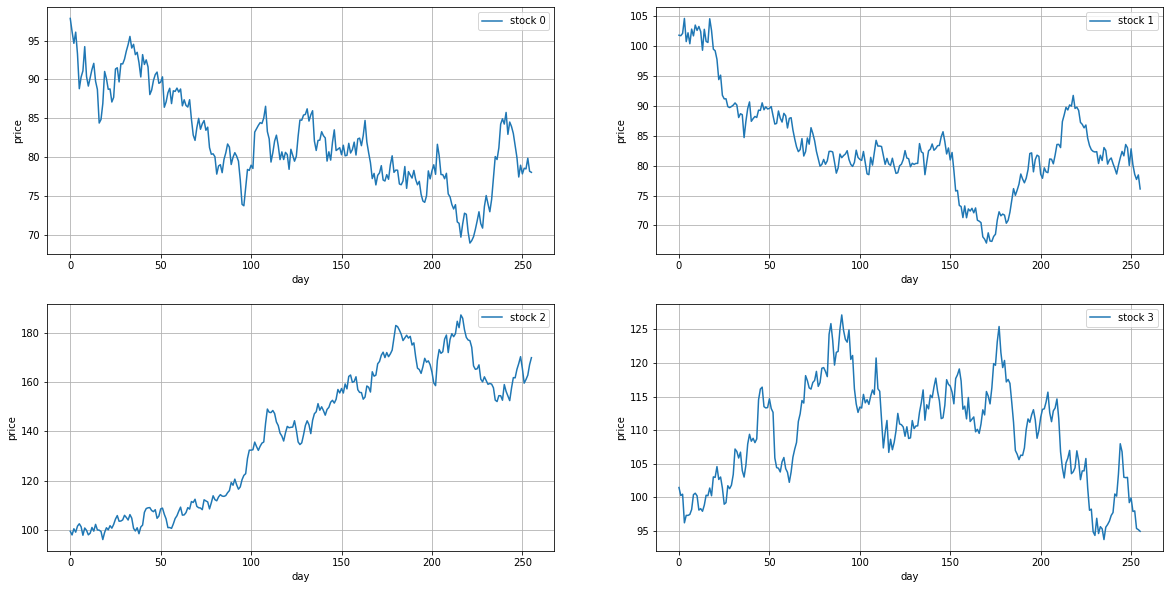

In [32]:
fig, ax = plt.subplots(figsize=(20,10), nrows=2, ncols=2)
for i in range(0, num_stocks):
    p = stock_prices[i]['stock_price']
    g = ax[int(i/2), i%2]
    g.plot(np.arange(0, trading_days), p, label=f'stock {i}')    
    g.grid()
    g.legend(loc=1)
    g.set_xlabel('day')
    g.set_ylabel('price')

## Question 2


Note that 100 strike call is actually in the money. According to Black-Scholes, $d1 = \ln(\frac{S}{K} + (r+\frac{1}{2}\sigma^2)\cdot t)*\frac{1}{\sigma \sqrt{t}}$, hence the ATM strike is $K = S*\exp(r+\frac{1}{2}\sigma^2\cdot t)$, which is larger than spot price.

For given base price, time to expiry, strike, rate and implied volatility, we can calculate the delta and value of the call option. In order to stay delta flat, when we first bought the call, we will sell some stocks. However, as time to expiry and stock price changed, we will need to re-hedge to stay delta flat. Take the example below, initially we sold 57 lots of stock. One day later, 

In [33]:
pricing_data['hedge'] = -(pricing_data['delta'] * contract_multiplier).astype(int)

In [34]:
pricing_data

,base_price,tte,option_price,delta,hedge
0,96.233,1.000,11.971,0.574,-57
1,98.265,0.996,13.136,0.598,-59
2,96.782,0.992,12.228,0.580,-57
3,98.867,0.988,13.437,0.605,-60
4,98.179,0.984,12.990,0.596,-59
5,98.941,0.980,13.419,0.605,-60
6,97.550,0.977,12.554,0.588,-58
7,96.113,0.973,11.688,0.570,-56
8,96.712,0.969,12.001,0.577,-57
9,94.383,0.965,10.661,0.547,-54


## Question 3

From put call parity we have $C_1 - P_1 = S - K_1\cdot\exp(-rt)$. 
If we can observe prices of put and call in strike $K_1$ and $K_2$, then we can calcualte the iimplied interest rate from the synsthetic swaps. $C_1-P_1 - C_2 + P_2 = (K_2 - K_1)\cdot\exp(-rt)$.

From price of put and call of strike $K_1$, we can calculate the implied spot price as $S=C_1 -P_1 + K_1 \cdot \exp(-rt)$.
Then we can calculate the implied forward as $S\cdot \exp(rt)$ 